In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, classification_report, confusion_matrix, f1_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import fbeta_score
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from datasets import load_dataset

dataset = load_dataset("Anthropic/hh-rlhf", data_dir="red-team-attempts")
ds = dataset["train"]

ds
print(ds.features)

{'transcript': Value('string'), 'min_harmlessness_score_transcript': Value('float64'), 'num_params': Value('string'), 'model_type': Value('string'), 'rating': Value('int64'), 'task_description': Value('string'), 'task_descripton_harmlessness_score': Value('float64'), 'red_team_member_id': Value('int64'), 'is_upworker': Value('bool'), 'tags': List(Value('string'))}


count    38961.000000
mean        -0.133606
std          1.790039
min         -7.537941
25%         -1.354373
50%          0.137786
75%          1.276099
max          6.611995
Name: min_harmlessness_score_transcript, dtype: float64
count    38961.000000
mean         1.609866
std          1.636358
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max          4.000000
Name: rating, dtype: float64


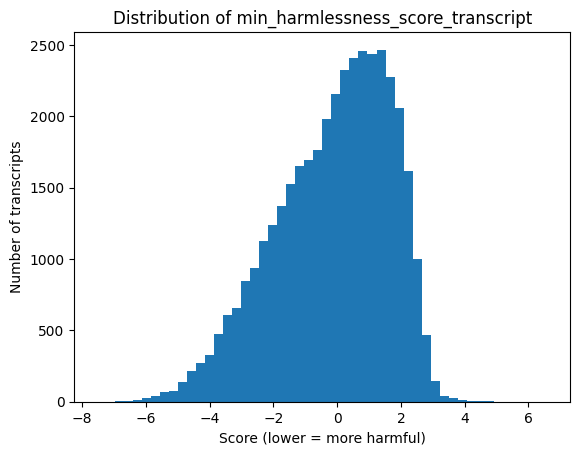

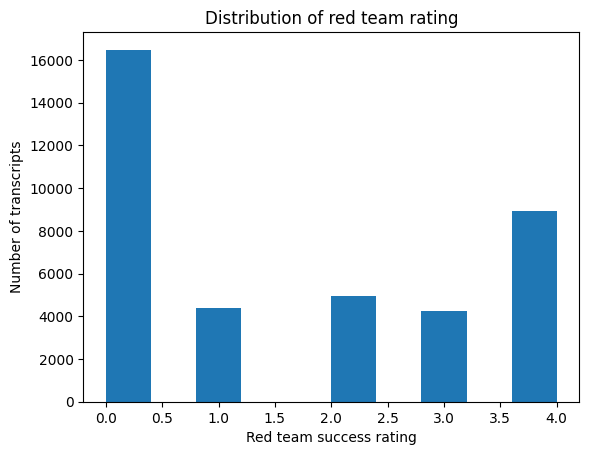

In [3]:
# Convert to DataFrame
df = ds.to_pandas()

# Inspect summary statistics
print(df['min_harmlessness_score_transcript'].describe())
print(df['rating'].describe())

# Optional: visualize distribution
plt.hist(df['min_harmlessness_score_transcript'], bins=50)
plt.title("Distribution of min_harmlessness_score_transcript")
plt.xlabel("Score (lower = more harmful)")
plt.ylabel("Number of transcripts")
plt.show()

plt.hist(df['rating'], bins=10)
plt.title("Distribution of red team rating")
plt.xlabel("Red team success rating")
plt.ylabel("Number of transcripts")
plt.show()


Class distribution:
label
BENIGN     12138
ABUSIVE    11763
Name: count, dtype: int64


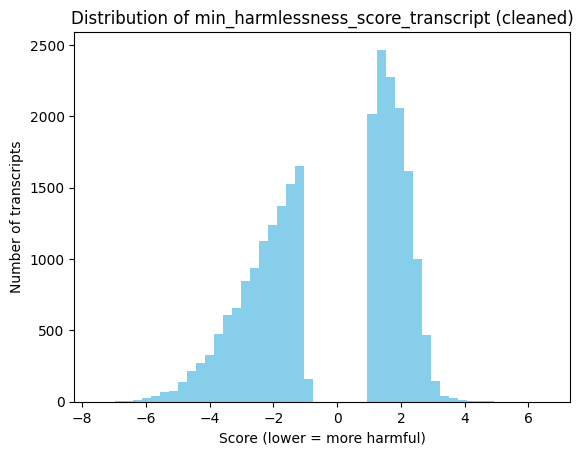

In [4]:
# Convert to DataFrame
df = ds.to_pandas()

# Step 1: Define thresholds
H_LOW = -1.0   # Anything below this is ABUSIVE
H_HIGH = 1.0   # Anything above this is BENIGN

# Step 2: Assign labels based on min_harmlessness_score_transcript
def label_row(score):
    if score < H_LOW:
        return "ABUSIVE"
    elif score > H_HIGH:
        return "BENIGN"
    else:
        return None  # borderline, we exclude these

df['label'] = df['min_harmlessness_score_transcript'].apply(label_row)

# Step 3: Drop borderline rows
df_clean = df.dropna(subset=['label']).reset_index(drop=True)

# Step 4: Inspect class counts
print("Class distribution:")
print(df_clean['label'].value_counts())

# Step 5: Optional: visualize distribution
plt.hist(df_clean['min_harmlessness_score_transcript'], bins=50, color='skyblue')
plt.title("Distribution of min_harmlessness_score_transcript (cleaned)")
plt.xlabel("Score (lower = more harmful)")
plt.ylabel("Number of transcripts")
plt.show()


Class counts:
label
BENIGN     12138
ABUSIVE    11763
Name: count, dtype: int64


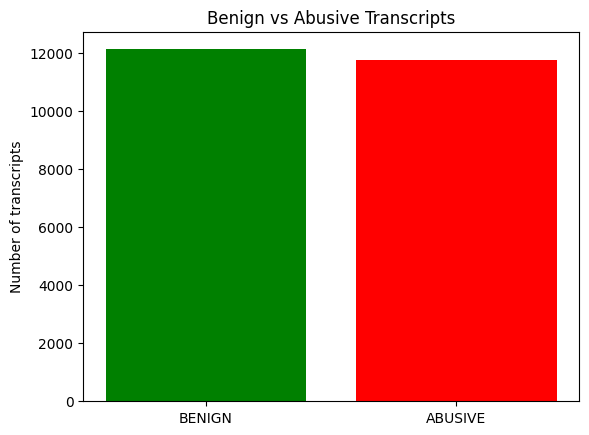

BENIGN: 12138 (50.78%)
ABUSIVE: 11763 (49.22%)


In [5]:
# Count examples per class
class_counts = df_clean['label'].value_counts()
print("Class counts:")
print(class_counts)

# Visualize class distribution
plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])
plt.title("Benign vs Abusive Transcripts")
plt.ylabel("Number of transcripts")
plt.show()

# Optional: compute class ratio
total = class_counts.sum()
for cls, count in class_counts.items():
    print(f"{cls}: {count} ({count/total:.2%})")


In [6]:
# Add binary label column BEFORE splitting
df_clean['label_binary'] = df_clean['label'].map({'BENIGN': 0, 'ABUSIVE': 1})

# Step 1: split out train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    df_clean,
    test_size=0.3,  # 30% goes to temp (val + test)
    stratify=df_clean['label_binary'],  # Use binary for stratification
    random_state=42
)

# Step 2: split temp into validation and test (15% each)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # half of temp → test, half → val
    stratify=temp_df['label_binary'],  # Use binary for stratification
    random_state=42
)

# Check sizes
print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

def preprocess(text):
    return text.lower()
    
train_texts = train_df['transcript'].apply(preprocess)
val_texts   = val_df['transcript'].apply(preprocess)
test_texts  = test_df['transcript'].apply(preprocess)

# Use binary labels (0/1) - NO LabelEncoder needed!
y_train = train_df['label_binary'].values  # 0/1 array
y_val   = val_df['label_binary'].values    # 0/1 array
y_test  = test_df['label_binary'].values   # 0/1 array

# Keep original string labels for display if needed
y_train_labels = train_df['label'].values  # 'ABUSIVE'/'BENIGN'
y_val_labels = val_df['label'].values
y_test_labels = test_df['label'].values

# Print mapping for clarity
print("\nLabel mapping (used throughout notebook):")
print("  0 = BENIGN")
print("  1 = ABUSIVE")
print(f"\nTrain set class distribution: {np.bincount(y_train)} (0=BENIGN, 1=ABUSIVE)")
print(f"Validation set class distribution: {np.bincount(y_val)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Train: 16730
Validation: 3585
Test: 3586

Label mapping (used throughout notebook):
  0 = BENIGN
  1 = ABUSIVE

Train set class distribution: [8496 8234] (0=BENIGN, 1=ABUSIVE)
Validation set class distribution: [1821 1764]
Test set class distribution: [1821 1765]


Best parameters: {'lr__C': 10, 'lr__solver': 'lbfgs', 'tfidf__max_df': 1.0, 'tfidf__max_features': 20000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
ABUSIVE = 1, BENIGN = 0
Validation ROC AUC (raw, uncalibrated): 0.9712


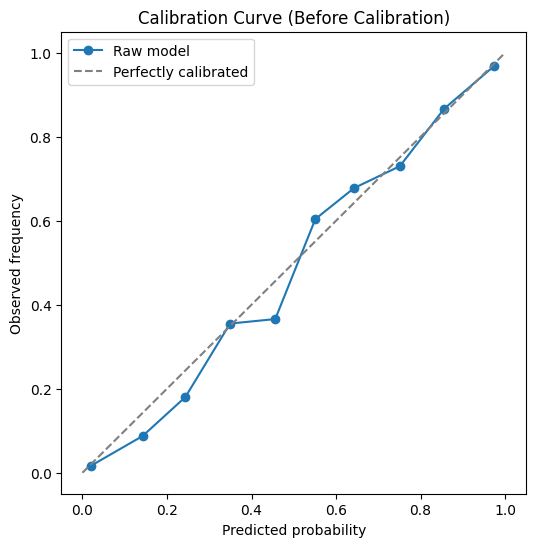

In [7]:
# --- Step 1: Define pipeline ---
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# --- Step 2: Define param grid for tuning ---
param_grid = {
    'tfidf__max_features': [5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__solver': ['lbfgs'],
}

# --- Step 3: GridSearchCV ---
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=0
)

# --- Step 4: Fit on training raw text ---
grid.fit(train_texts, y_train)  # y_train is 0/1 (BENIGN=0, ABUSIVE=1)
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Positive class is 1 (ABUSIVE)
pos_class = 1  # ABUSIVE = 1, BENIGN = 0
print(f"ABUSIVE = {pos_class}, BENIGN = {0}")

# --- Evaluate raw model ---
probs_val_raw = best_model.predict_proba(val_texts)[:, pos_class]  # Index 1 for ABUSIVE
roc_auc_raw = roc_auc_score(y_val, probs_val_raw)
print(f"Validation ROC AUC (raw, uncalibrated): {roc_auc_raw:.4f}")

# Calibration curve - pos_label=1 (ABUSIVE)
fraction_pos_raw, mean_pred_raw = calibration_curve(
    y_val, probs_val_raw, n_bins=10, pos_label=pos_class  # pos_label=1
)

plt.figure(figsize=(6,6))
plt.plot(mean_pred_raw, fraction_pos_raw, marker='o', label="Raw model")
plt.plot([0,1], [0,1], '--', color='gray', label='Perfectly calibrated')
plt.title("Calibration Curve (Before Calibration)")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.legend()
plt.show()

Validation ROC AUC (calibrated): 0.9716


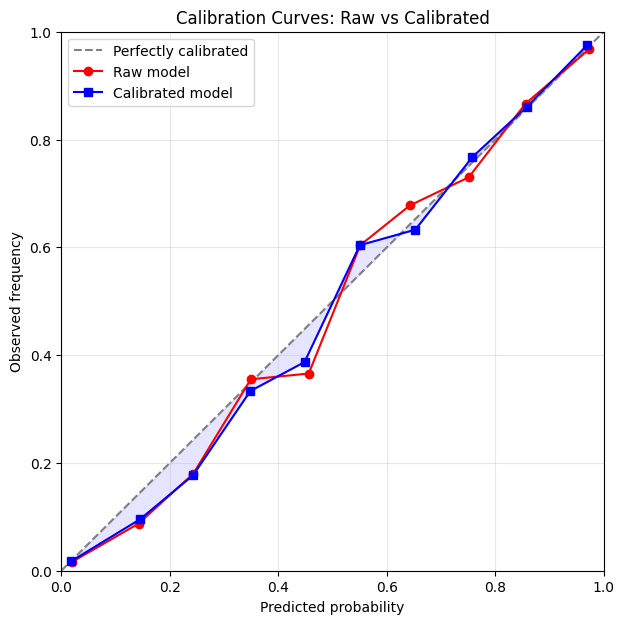

In [8]:
# Calibrated classifier (fit fresh on training)
calibrated_model = CalibratedClassifierCV(best_model, method="isotonic", cv=5)
calibrated_model.fit(train_texts, y_train)

# Positive class is 1 (ABUSIVE)
pos_class = 1

# --- Evaluate on validation set ---
probs_val_cal = calibrated_model.predict_proba(val_texts)[:, pos_class]
roc_auc_cal = roc_auc_score(y_val, probs_val_cal)
print(f"Validation ROC AUC (calibrated): {roc_auc_cal:.4f}")

# Calibration curve - pos_label=1
fraction_pos_cal, mean_pred_cal = calibration_curve(
    y_val, probs_val_cal, n_bins=10, pos_label=1  # pos_label=1
)

plt.figure(figsize=(7,7))
plt.plot([0,1], [0,1], '--', color='gray', label='Perfectly calibrated')
plt.plot(mean_pred_raw, fraction_pos_raw, marker='o', color='red', linestyle='-', label='Raw model')
plt.plot(mean_pred_cal, fraction_pos_cal, marker='s', color='blue', linestyle='-', label='Calibrated model')
plt.fill_between(mean_pred_cal, fraction_pos_cal, mean_pred_cal, color='blue', alpha=0.1)
plt.title("Calibration Curves: Raw vs Calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Test ROC AUC (calibrated): 0.9679


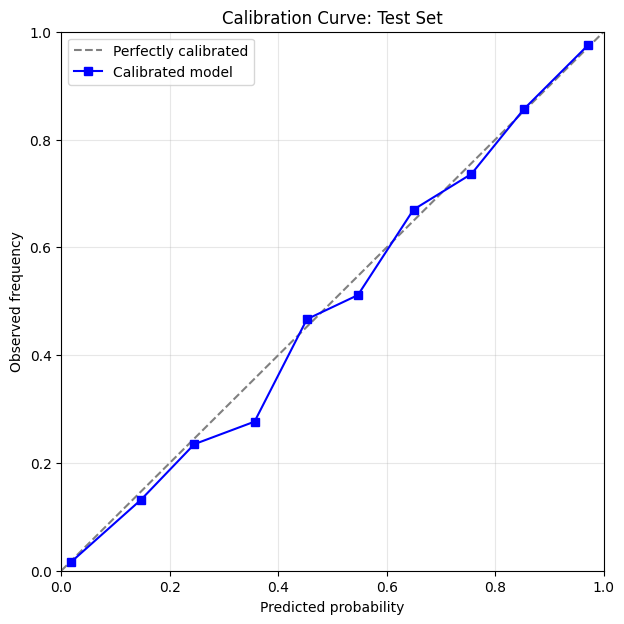

In [9]:
# --- Test set evaluation ---
probs_test = calibrated_model.predict_proba(test_texts)[:, pos_class]  # pos_class=1
roc_auc_test = roc_auc_score(y_test, probs_test)
print(f"Test ROC AUC (calibrated): {roc_auc_test:.4f}")

# Calibration curve on test set - pos_label=1
fraction_pos_test, mean_pred_test = calibration_curve(
    y_test, probs_test, n_bins=10, pos_label=1  # pos_label=1
)

plt.figure(figsize=(7,7))
plt.plot([0,1], [0,1], '--', color='gray', label='Perfectly calibrated')
plt.plot(mean_pred_test, fraction_pos_test, marker='s', color='blue', linestyle='-', label='Calibrated model')
plt.title("Calibration Curve: Test Set")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Best threshold for ABUSIVE class (from validation set): 0.455, F1=0.917


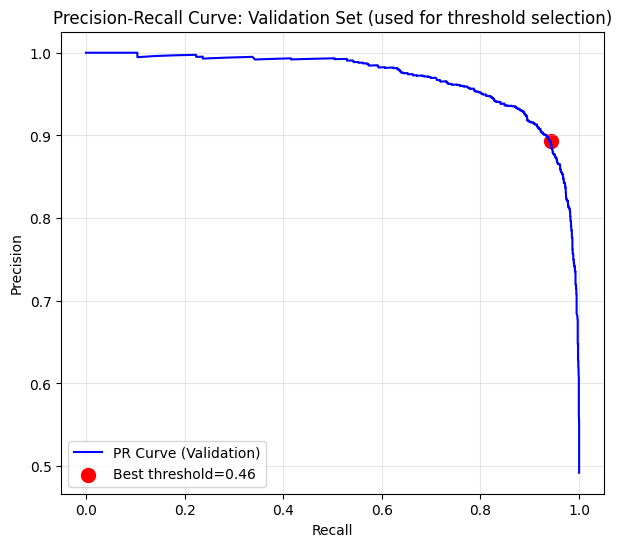

Confusion Matrix on Test Set (using threshold from validation):
[[1606  215]
 [ 120 1645]]

Classification Report on Test Set:
              precision    recall  f1-score   support

  BENIGN (0)       0.93      0.88      0.91      1821
 ABUSIVE (1)       0.88      0.93      0.91      1765

    accuracy                           0.91      3586
   macro avg       0.91      0.91      0.91      3586
weighted avg       0.91      0.91      0.91      3586



In [15]:
# --- Step 1: Compute precision, recall, thresholds ON VALIDATION SET ---
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, probs_val_cal, pos_label=1)  # pos_label=1

# --- Step 2: Compute F1 scores at each threshold ON VALIDATION SET ---
f1_scores_val = 2 * (precision_val * recall_val) / (precision_val + recall_val + 1e-10)

# --- Step 3: Find threshold with highest F1 ON VALIDATION SET ---
best_idx_val = f1_scores_val.argmax()
# thresholds_val has length = len(precision_val)-1, so need to check index
best_threshold_val = thresholds_val[best_idx_val] if best_idx_val < len(thresholds_val) else 0.5
print(f"Best threshold for ABUSIVE class (from validation set): {best_threshold_val:.3f}, F1={f1_scores_val[best_idx_val]:.3f}")

# --- Step 4: Plot Precision-Recall curve FOR VALIDATION SET ---
plt.figure(figsize=(7,6))
plt.plot(recall_val, precision_val, label="PR Curve (Validation)", color='blue')
plt.scatter(recall_val[best_idx_val], precision_val[best_idx_val], color='red', s=100, 
            label=f"Best threshold={best_threshold_val:.2f}")
plt.title("Precision-Recall Curve: Validation Set (used for threshold selection)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# --- Step 5: Apply threshold to TEST SET ---
y_pred_test_thresholded = [1 if p >= best_threshold_val else 0 for p in probs_test]  # 1=ABUSIVE, 0=BENIGN

# --- Step 6: Confusion matrix and classification report ON TEST SET ---
print("Confusion Matrix on Test Set (using threshold from validation):")
print(confusion_matrix(y_test, y_pred_test_thresholded))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test_thresholded, 
                            target_names=['BENIGN (0)', 'ABUSIVE (1)']))


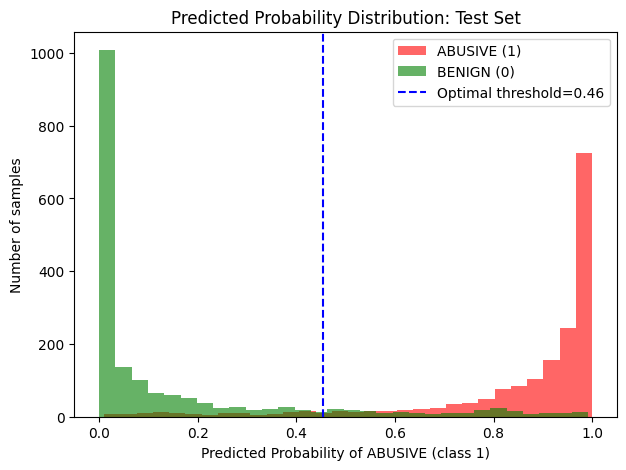

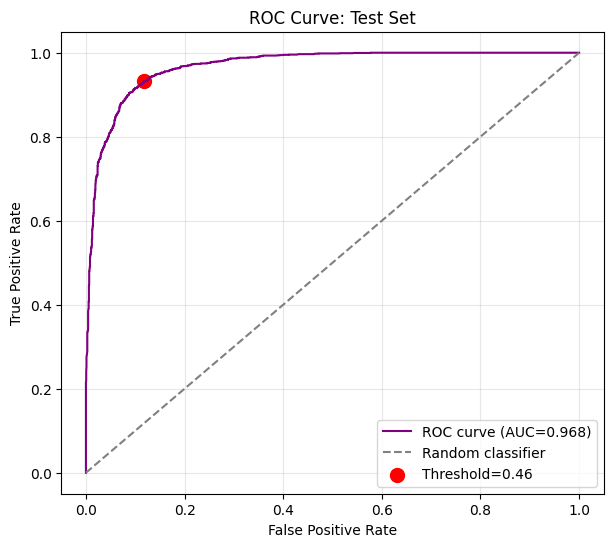

At threshold=0.455:
  False Positive Rate: 0.119
  True Positive Rate: 0.932


In [16]:
# --- Step 1: Plot histogram of predicted probabilities ---
plt.figure(figsize=(7,5))

# Use binary labels (0/1) to separate the distributions
plt.hist(probs_test[y_test == 1], bins=30, alpha=0.6, label='ABUSIVE (1)', color='red')
plt.hist(probs_test[y_test == 0], bins=30, alpha=0.6, label='BENIGN (0)', color='green')
plt.axvline(best_threshold_val, color='blue', linestyle='--', 
            label=f'Optimal threshold={best_threshold_val:.2f}')
plt.title("Predicted Probability Distribution: Test Set")
plt.xlabel("Predicted Probability of ABUSIVE (class 1)")
plt.ylabel("Number of samples")
plt.legend()
plt.show()


# --- Step 2: Plot ROC curve with thresholds ---
# y_test is already binary (0/1), no mapping needed!
fpr, tpr, roc_thresholds = roc_curve(y_test, probs_test)

# Find the point on ROC curve closest to our chosen threshold
# Get index of threshold in roc_thresholds closest to best_threshold_val
closest_idx = np.abs(roc_thresholds - best_threshold_val).argmin()

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='purple', label=f"ROC curve (AUC={roc_auc_test:.3f})")
plt.plot([0,1], [0,1], '--', color='gray', label='Random classifier')
plt.scatter(fpr[closest_idx], tpr[closest_idx], color='red', s=100, 
            label=f"Threshold={best_threshold_val:.2f}")
plt.title("ROC Curve: Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Optional: Show the FPR/TPR at chosen threshold
print(f"At threshold={best_threshold_val:.3f}:")
print(f"  False Positive Rate: {fpr[closest_idx]:.3f}")
print(f"  True Positive Rate: {tpr[closest_idx]:.3f}")

F-BETA ANALYSIS ON VALIDATION SET (For Decision Making)


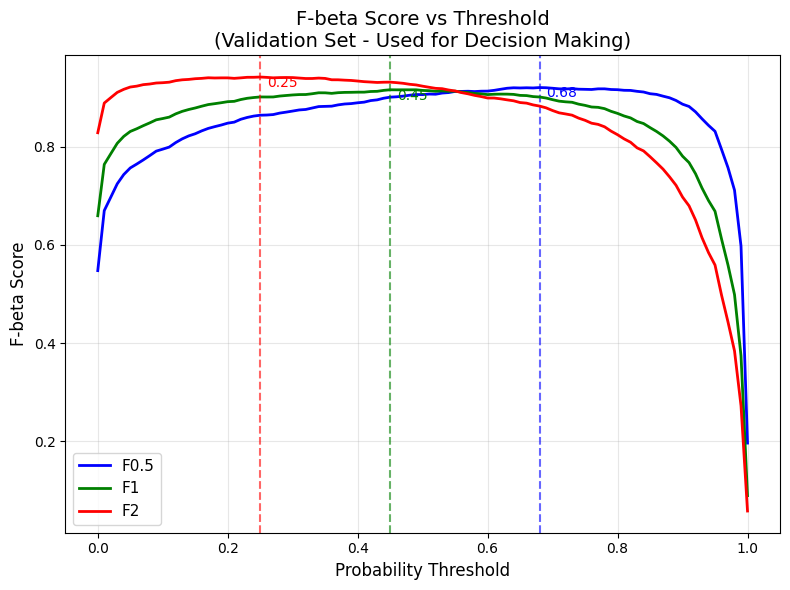


Optimal thresholds from VALIDATION set (for decision making):
  F0.5: threshold = 0.680, score = 0.921
  F1: threshold = 0.450, score = 0.917
  F2: threshold = 0.250, score = 0.942

✓ F1-optimized threshold from validation: 0.450
  (Previously selected threshold was: 0.455)

F-BETA ON TEST SET (Illustration Only - Shows Generalization)


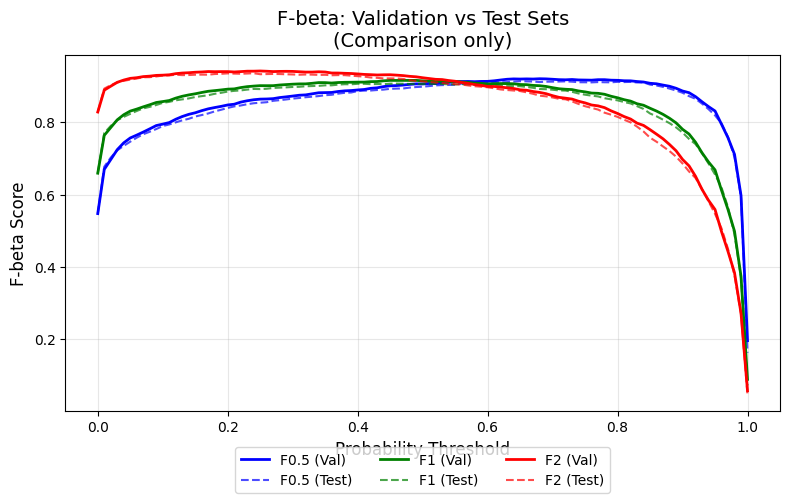


--------------------------------------------------
Comparing Different Threshold Choices on TEST SET:
--------------------------------------------------

F0.5 (precision-focused) (threshold=0.680):
  Precision: 0.925
  Recall:    0.862
  F1-score:  0.893

F1 (balanced) (threshold=0.450):
  Precision: 0.884
  Recall:    0.932
  F1-score:  0.907

F2 (recall-focused) (threshold=0.250):
  Precision: 0.831
  Recall:    0.963
  F1-score:  0.892

Previously selected (threshold=0.455):
  Precision: 0.884
  Recall:    0.932
  F1-score:  0.908

METHODOLOGICAL NOTE
• Validation set used for all threshold selection decisions
• Test set used only for final unbiased evaluation
• F-beta analysis shows trade-offs between precision (F0.5) and recall (F2)
• Previously selected threshold: 0.455 (from PR curve analysis)
• F1-optimized threshold from this analysis: 0.450
✓ Thresholds are similar (~0.005 difference)


In [22]:
# ============================================================================
# F-BETA ANALYSIS ON VALIDATION SET (For Threshold Selection Decisions)
# ============================================================================
print("=" * 60)
print("F-BETA ANALYSIS ON VALIDATION SET (For Decision Making)")
print("=" * 60)

# --- Step 1: Define beta values ---
beta_values = [0.5, 1, 2]  # F0.5 favors precision, F1 balanced, F2 favors recall
colors = ['blue', 'green', 'red']  # Assign color per beta

# --- Step 2: Compute F-beta scores across thresholds (VALIDATION SET) ---
thresholds = np.linspace(0, 1, 101)
f_beta_scores_val = {beta: [] for beta in beta_values}

# y_val is already binary (0/1) numpy array - NO MAPPING NEEDED!
for thresh in thresholds:
    y_pred_val = (probs_val_cal >= thresh).astype(int)  # probs_val_cal from validation
    for beta in beta_values:
        f_beta_scores_val[beta].append(fbeta_score(y_val, y_pred_val, beta=beta))

# --- Step 3: Plot F-beta curves (Validation) ---
plt.figure(figsize=(8,6))
optimal_thresholds_val = {}

for i, beta in enumerate(beta_values):
    plt.plot(thresholds, f_beta_scores_val[beta], label=f'F{beta}', color=colors[i], linewidth=2)
    # Optimal threshold for this beta on validation set
    opt_idx = np.argmax(f_beta_scores_val[beta])
    opt_thresh = thresholds[opt_idx]
    optimal_thresholds_val[beta] = opt_thresh
    plt.axvline(opt_thresh, color=colors[i], linestyle='--', alpha=0.6, linewidth=1.5)
    plt.text(opt_thresh+0.01, f_beta_scores_val[beta][opt_idx]-0.02, 
             f'{opt_thresh:.2f}', color=colors[i], fontsize=10)

plt.title("F-beta Score vs Threshold\n(Validation Set - Used for Decision Making)", fontsize=14)
plt.xlabel("Probability Threshold", fontsize=12)
plt.ylabel("F-beta Score", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# --- Step 4: Print optimal thresholds from validation ---
print("\nOptimal thresholds from VALIDATION set (for decision making):")
for beta, thresh in optimal_thresholds_val.items():
    max_score = max(f_beta_scores_val[beta])
    print(f"  F{beta}: threshold = {thresh:.3f}, score = {max_score:.3f}")

# Highlight which threshold we actually chose (F1)
chosen_threshold_val = optimal_thresholds_val[1]  # F1 threshold
print(f"\n✓ F1-optimized threshold from validation: {chosen_threshold_val:.3f}")
print(f"  (Previously selected threshold was: {best_threshold_val:.3f})")

# ============================================================================
# F-BETA ON TEST SET (Illustration Only - Not for Decisions)
# ============================================================================
print("\n" + "=" * 60)
print("F-BETA ON TEST SET (Illustration Only - Shows Generalization)")
print("=" * 60)

# --- Compute on test set for illustration ---
f_beta_scores_test = {beta: [] for beta in beta_values}
# y_test is already binary (0/1) numpy array - NO MAPPING NEEDED!

for thresh in thresholds:
    y_pred_test = (probs_test >= thresh).astype(int)
    for beta in beta_values:
        f_beta_scores_test[beta].append(fbeta_score(y_test, y_pred_test, beta=beta))

# --- Plot test curves (dashed lines for comparison) ---
plt.figure(figsize=(8,6))

for i, beta in enumerate(beta_values):
    # Plot validation (solid) and test (dashed) for comparison
    plt.plot(thresholds, f_beta_scores_val[beta], label=f'F{beta} (Val)', color=colors[i], linewidth=2)
    plt.plot(thresholds, f_beta_scores_test[beta], label=f'F{beta} (Test)', color=colors[i], 
             linestyle='--', linewidth=1.5, alpha=0.7)

plt.title("F-beta: Validation vs Test Sets\n(Comparison only)", fontsize=14)
plt.xlabel("Probability Threshold", fontsize=12)
plt.ylabel("F-beta Score", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust for legend
plt.show()

# --- Compare different threshold choices on TEST SET ---
print("\n" + "-" * 50)
print("Comparing Different Threshold Choices on TEST SET:")
print("-" * 50)

# Test performance with different threshold choices
threshold_options = {
    'F0.5 (precision-focused)': optimal_thresholds_val[0.5],
    'F1 (balanced)': optimal_thresholds_val[1],
    'F2 (recall-focused)': optimal_thresholds_val[2],
    'Previously selected': best_threshold_val
}

for name, thresh in threshold_options.items():
    y_pred_test_option = (probs_test >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_test_option)
    recall = recall_score(y_test, y_pred_test_option)
    f1 = f1_score(y_test, y_pred_test_option)
    
    print(f"\n{name} (threshold={thresh:.3f}):")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-score:  {f1:.3f}")

# ============================================================================
# KEY TAKEAWAY
# ============================================================================
print("\n" + "=" * 60)
print("METHODOLOGICAL NOTE")
print("=" * 60)
print("• Validation set used for all threshold selection decisions")
print("• Test set used only for final unbiased evaluation")
print("• F-beta analysis shows trade-offs between precision (F0.5) and recall (F2)")
print(f"• Previously selected threshold: {best_threshold_val:.3f} (from PR curve analysis)")
print(f"• F1-optimized threshold from this analysis: {chosen_threshold_val:.3f}")

if abs(best_threshold_val - chosen_threshold_val) < 0.02:
    print(f"✓ Thresholds are similar (~{abs(best_threshold_val - chosen_threshold_val):.3f} difference)")
else:
    print(f"⚠ Note: Thresholds differ by {abs(best_threshold_val - chosen_threshold_val):.3f}")
    print("  You may want to choose one consistently for your final model.")

In [24]:
# --- 1️⃣ Save the calibrated model ---
model_filename = "abuse_detector_calibrated.pkl"
joblib.dump(calibrated_model, model_filename)
print(f"Calibrated model saved as {model_filename}")

# --- 2️⃣ Save label mapping and optimal threshold ---
# Use the actual threshold you selected (0.455) or the one from F-beta analysis
label_mapping = {'ABUSIVE': 1, 'BENIGN': 0}

# Choose which threshold to use - either the one from PR curve or F-beta analysis
optimal_threshold = best_threshold_val  # 0.455 from your PR curve analysis
# OR: optimal_threshold = chosen_threshold_val  # If you prefer the F-beta optimized one

# Also include TF-IDF configuration if needed for preprocessing consistency
config = {
    "label_mapping": label_mapping,
    "optimal_threshold": optimal_threshold,
    "positive_class": "ABUSIVE",
    "model_version": "1.0",
    "created_date": pd.Timestamp.now().strftime("%Y-%m-%d"),
    "threshold_selection_method": "PR curve F1 optimization"  # or "F-beta F1 optimization"
}

config_filename = "abuse_detector_config.pkl"
joblib.dump(config, config_filename)
print(f"Configuration saved as {config_filename}")
print(f"  - Optimal threshold: {optimal_threshold:.3f}")
print(f"  - Label mapping: {label_mapping}")

# --- 3️⃣ Helper prediction function with better error handling ---
def predict_abuse(texts, model=calibrated_model, config=config, preprocess_func=None):
    """
    Predict ABUSIVE vs BENIGN with calibrated probabilities.
    
    Parameters:
    -----------
    texts : list of str or single str
        Input text(s) to classify
    model : sklearn model
        Trained classifier (default: calibrated_model)
    config : dict
        Configuration with label mapping and threshold
    preprocess_func : callable, optional
        Function to preprocess text (default: lowercasing)
        
    Returns:
    --------
    labels : list
        Predicted labels ('ABUSIVE' or 'BENIGN')
    probs : list
        Probabilities for ABUSIVE class
    """
    # Handle single string input
    if isinstance(texts, str):
        texts = [texts]
    
    # Apply preprocessing if function provided
    if preprocess_func is None:
        # Default preprocessing (same as used during training)
        texts_processed = [t.lower() for t in texts]
    else:
        texts_processed = [preprocess_func(t) for t in texts]
    
    # Get probabilities for positive class (ABUSIVE=1)
    try:
        # Get index of positive class in model's classes array
        pos_class_index = list(model.classes_).index(config['label_mapping']['ABUSIVE'])
        probs = model.predict_proba(texts_processed)[:, pos_class_index]
    except ValueError as e:
        raise ValueError(f"Model classes {model.classes_} don't match config mapping {config['label_mapping']}") from e
    
    # Apply threshold to get labels
    labels = ['ABUSIVE' if p >= config['optimal_threshold'] else 'BENIGN' for p in probs]
    
    return labels, probs.tolist()

# --- 4️⃣ Example usage with more realistic examples ---
example_texts = [
    "I want to hurt you badly and make you suffer",
    "Hello, how are you doing today? I hope you're having a nice day.",
    "I hate you and wish you were never born",
    "Could you please help me with this task?",
    "You're worthless and should disappear"
]

print("\n" + "="*60)
print("EXAMPLE PREDICTIONS")
print("="*60)

pred_labels, pred_probs = predict_abuse(example_texts)
for t, l, p in zip(example_texts, pred_labels, pred_probs):
    # Truncate long text for display
    display_text = t[:50] + "..." if len(t) > 50 else t
    print(f"Text: {display_text}")
    print(f"  Predicted: {l:<8} Prob(ABUSIVE)={p:.3f} {'(⚠️ ABOVE THRESHOLD)' if p >= optimal_threshold else ''}\n")

# --- 5️⃣ Test loading the saved model ---
print("\n" + "="*60)
print("TESTING SAVED MODEL LOADING")
print("="*60)

try:
    # Load the saved model and config
    loaded_model = joblib.load(model_filename)
    loaded_config = joblib.load(config_filename)
    
    # Test with one example
    test_text = ["This is a test message"]
    labels, probs = predict_abuse(test_text, model=loaded_model, config=loaded_config)
    
    print(f"✓ Model loaded successfully")
    print(f"✓ Configuration loaded: threshold={loaded_config['optimal_threshold']}")
    print(f"✓ Test prediction works: {labels[0]} (p={probs[0]:.3f})")
    
except Exception as e:
    print(f"✗ Error loading model: {e}")

Calibrated model saved as abuse_detector_calibrated.pkl
Configuration saved as abuse_detector_config.pkl
  - Optimal threshold: 0.455
  - Label mapping: {'ABUSIVE': 1, 'BENIGN': 0}

EXAMPLE PREDICTIONS
Text: I want to hurt you badly and make you suffer
  Predicted: BENIGN   Prob(ABUSIVE)=0.335 

Text: Hello, how are you doing today? I hope you're havi...
  Predicted: BENIGN   Prob(ABUSIVE)=0.006 

Text: I hate you and wish you were never born
  Predicted: BENIGN   Prob(ABUSIVE)=0.106 

Text: Could you please help me with this task?
  Predicted: BENIGN   Prob(ABUSIVE)=0.013 

Text: You're worthless and should disappear
  Predicted: BENIGN   Prob(ABUSIVE)=0.078 


TESTING SAVED MODEL LOADING
✓ Model loaded successfully
✓ Configuration loaded: threshold=0.4550451087538841
✓ Test prediction works: BENIGN (p=0.013)


In [25]:
predict_abuse(["hi, how's life", "what about you?"])

(['BENIGN', 'BENIGN'], [0.0020312943056737037, 0.038742727537239056])